# 05 - Topic Modeling - Exercise 3

In [1]:
import pandas as pd
import numpy as np
import gensim

C:\Users\francois\Anaconda3\lib\site-packages\gensim\utils.py:840: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\francois\Anaconda3\lib\site-packages\gensim\utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [4]:
### ONLY RUN ONCE ####
# import nltk
# nltk.download('wordnet')

In [5]:
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# create DataFrame
path_emails = 'hillary-clinton-emails/Emails.csv'
emails = pd.read_csv(path_emails, usecols = ['SenderPersonId', 'ExtractedSubject', 'ExtractedBodyText'])

# drop records where both ExtractedSubject and ExtractedBodyText are NaN
emails.dropna(axis=0, thresh=2, subset=[['ExtractedSubject', 'ExtractedBodyText']], inplace=True)
emails.fillna(' ', inplace = True)

# group emails by sender
emails_raw = []

for sender in emails.groupby('SenderPersonId'):
    grouped_emails = ''
    
    for subject, body in zip(sender[1]['ExtractedSubject'], sender[1]['ExtractedBodyText']):
        grouped_emails += (subject + ' ' + body + ' ')
    
    emails_raw.append(grouped_emails)

# tokenization
email_tokens = []

for email in emails_raw:
    email_tokens.append(regexp_tokenize(email, pattern='\w+'))

# remove stopwords and digits/numbers
stop_words = set(stopwords.words('english'))
stopwords_emails = ['fyi', 'fm', 'am', 'pm', 'n\'t', 'sent', 'from', 'to', 'subject', 'fw', 'fwd', 'fvv',
                    'cc', 'bcc', 'attachments', 're', 'date', 'html', 'php']
stop_words.update(stopwords_emails)

email_clean_tokens = []

for email in email_tokens:
    clean_tokens = [token for token in email if token.lower() not in stop_words and token.isdigit() == False]
    email_clean_tokens.append(clean_tokens)

# lemmatization
# stemmer = PorterStemmer()
wnl = WordNetLemmatizer()

email_lemma = []

for email in email_clean_tokens:
    lemma = [wnl.lemmatize(token.lower()) for token in email]
    email_lemma.append(lemma)
    
# remove tokens that are too small
email_clean = []

for email in email_lemma:
    clean = [token for token in email if len(token) > 1]
    email_clean.append(clean)

In [6]:
dictionary = gensim.corpora.Dictionary(email_clean)
corpus = [dictionary.doc2bow(email) for email in email_clean]

In [7]:
number_topics = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

for n in number_topics:
    lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=n, id2word=dictionary, passes=10)
   
    print('#### Model with', n, 'topics ####')
   
    topic_id = 1
   
    for topic in lda_model.show_topics(num_topics=n, num_words=10, log=False, formatted=False):
        
        string_words = ''
        
        for word in topic[1]:
            string_words += (word[0] + ' ')
        
        print('topic #', topic_id, ':', string_words)

        topic_id += 1

KeyboardInterrupt: 

# Bonus Part

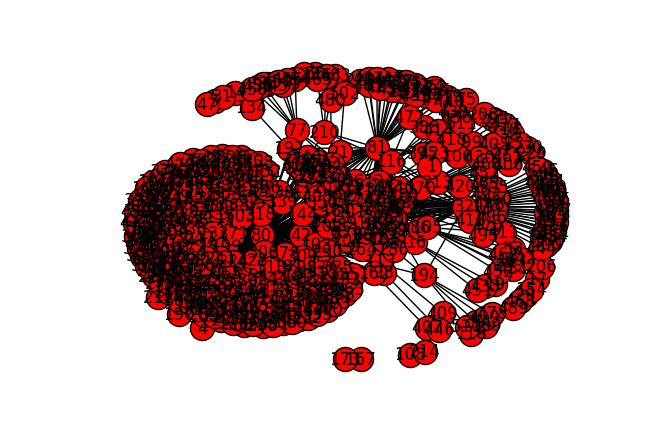

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
clinton_emails = pd.read_csv('hillary-clinton-emails/emails.csv')
mail_aliases = pd.read_csv('hillary-clinton-emails/Aliases.csv')
clinton_emails_receivers = pd.read_csv('hillary-clinton-emails/EmailReceivers.csv')

liste = []
for i, j in clinton_emails.iterrows():
    email, sender = j[['Id', 'SenderPersonId']]
    
    receivers = []
    for i, j in clinton_emails_receivers[clinton_emails_receivers['EmailId'] == email].iterrows():
        receivers.append(mail_aliases[mail_aliases['PersonId'] == j['PersonId']]['PersonId'].iloc[0])
    if(np.isnan(sender)):
        sender = -1
        
    liste.append(((int)(sender), receivers))

G = nx.Graph()


for sender, receivers in liste:
    for receiver in receivers:
        G.add_edge(sender, receiver)

nx.draw(G, with_labels=True)
plt.show()




In [3]:
import pythoncom
partition = community.best_partition(G)
values = [partition.get(node) for node in G.nodes()]

nx.draw_spring(G, cmap = plt.get_cmap('jet'), node_color = values, node_size = 10, with_labels=True)
plt.show()

NameError: name 'community' is not defined